In [20]:
import numpy as np
import os 
import pickle 

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import mpl_toolkits.mplot3d.axes3d as p3
import mpl_toolkits.mplot3d as plt3d
import matplotlib.animation as animation

%matplotlib widget


In [2]:
segmentation_list = [
("/Users/Alex/Downloads/IR_134/Segmentation RT 134/Segmentation RT 134.seg.nrrd", "Segmentation RT 134"),
("/Users/Alex/Downloads/IR_134/Segmentation LT 134/Segmentation LT 134.seg.nrrd", "Segmentation LT 134"),
("/Users/Alex/Downloads/IR_138/Segmentation RT 138/Segmentation RT 138.seg.nrrd", "Segmentation RT 138"),
("/Users/Alex/Downloads/IR_138/Segmentation LT 138/Segmentation LT 138.seg.nrrd", "Segmentation LT 138"),
("/Users/Alex/Downloads/IR_140/Segmentation RT 140/Segmentation RT 140.seg.nrrd", "Segmentation RT 140"),
("/Users/Alex/Downloads/IR_140/Segmentation LT 140/Segmentation LT 140.seg.nrrd", "Segmentation LT 140"),
("/Users/Alex/Downloads/IR_144/Segmentation RT 144/Segmentation RT 144.seg.nrrd", "Segmentation RT 144"),
("/Users/Alex/Downloads/IR_144/Segmentation LT 144/Segmentation LT 144.seg.nrrd", "Segmentation LT 144"),
("/Users/Alex/Downloads/IR_146/Segmentation RT 146/Segmentation RT 146.seg.nrrd", "Segmentation RT 146"),
("/Users/Alex/Downloads/IR_146/Segmentation LT 146/Segmentation LT 146.seg.nrrd", "Segmentation LT 146"),
("/Users/Alex/Downloads/IR_148/Segmentation LT 148/Segmentation LT 148.seg.nrrd", "Segmentation LT 148"),
("/Users/Alex/Downloads/IR_150/Segmentation RT 150/Segmentation RT 150.seg.nrrd", "Segmentation RT 150"),
("/Users/Alex/Downloads/IR_150/Segmentation LT 150/Segmentation LT 150.seg.nrrd", "Segmentation LT 150"),
("/Users/Alex/Downloads/IR_144\ but\ not\ actually/Segmentation RT lly/Segmentation RT 144.seg.nrrd", "Segmentation RT 147"),
("/Users/Alex/Downloads/IR_144\ but\ not\ actually/Segmentation LT 144/Segmentation LT 144.seg.nrrd", "Segmentation LT 147"),
]

In [3]:
def read_from_file(name):
    '''
        Return loaded object given by input name
    '''
    print 'reading structures from pickle'
    print '------------------------------'

    path = os.getcwd() + '/pickles/' + name + '.pkl'
    file = open(path, 'rb')
    new_obj = pickle.load(file)
    file.close()

    return new_obj

In [4]:
vis_id = 1
mean_shape, Gs, Ws, Ps, corresponded_targets, disparities = read_from_file("LOO_" + segmentation_list[vis_id][1].replace(" ", ""))

reading structures from pickle
------------------------------


<IPython.core.display.Javascript object>


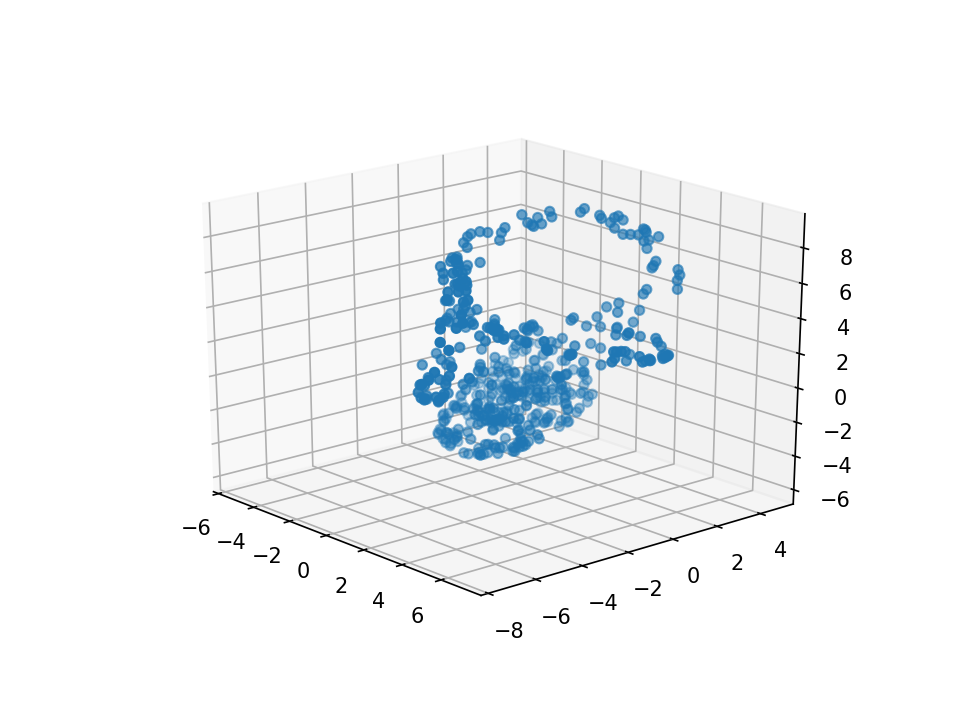

In [21]:
fig = plt.figure()
ax = fig.add_subplot(111, projection="3d")
ax.scatter(mean_shape[:,0], mean_shape[:,1], mean_shape[:,2])

<IPython.core.display.Javascript object>


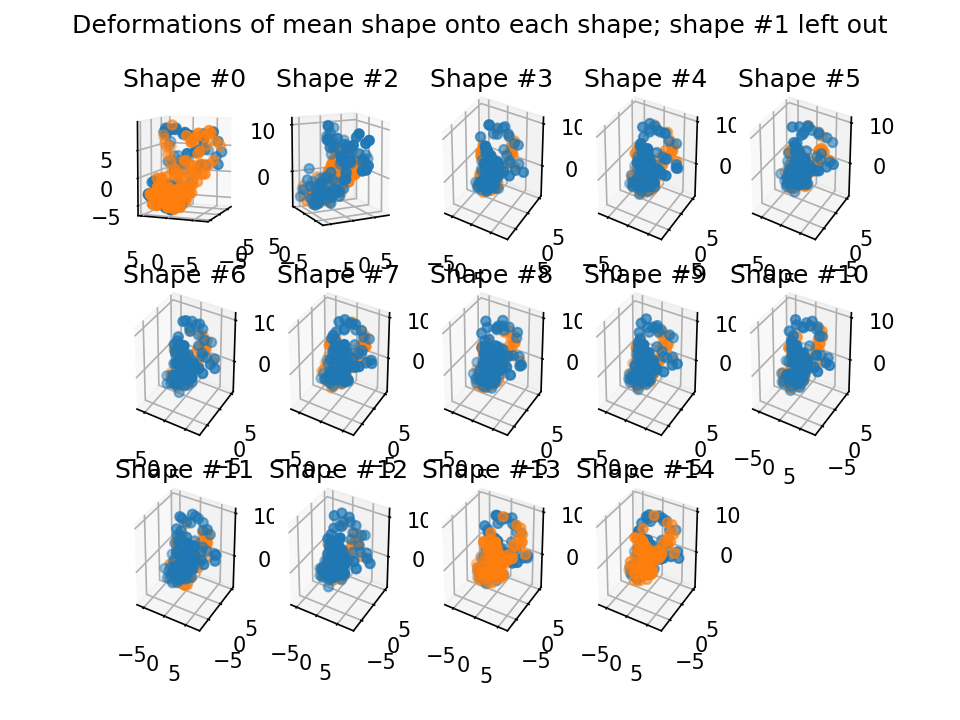

Text(0.5,0.98,'Deformations of mean shape onto each shape; shape #1 left out')

In [22]:
fig = plt.figure()

for register_idx in range(len(corresponded_targets)):
    if register_idx > len(corresponded_targets): 
        break
    ax = fig.add_subplot(3, 5, register_idx + 1, projection='3d')

    # target_cloud = corresponded_targets[vis_idx]
    # ax.scatter(target_cloud[:,0], target_cloud[:,1], target_cloud[:,2])

    transformed = mean_shape + np.dot(Gs[register_idx], Ws[register_idx])
    ax.scatter(transformed[::5,0], transformed[::5,1], transformed[::5,2])

    corresponded = corresponded_targets[register_idx]
    ax.scatter(corresponded[::5,0], corresponded[::5,1], corresponded[::5,2])

    shape_num = register_idx + 1 if vis_id <= register_idx else register_idx
    ax.set_title('Shape #%d'%shape_num)

fig.suptitle("Deformations of mean shape onto each shape; shape #%d left out"%vis_id)

In [24]:
deformations = np.array([np.dot(G, W) for G, W in zip(Gs, Ws)])
nshape, npoint, nd = deformations.shape
deformations = deformations.reshape((nshape, npoint*nd), order="F")
u, s, vh = np.linalg.svd(deformations, full_matrices=False)
u.shape, s.shape, vh.shape

((14, 14), (14,), (14, 1500))

<IPython.core.display.Javascript object>


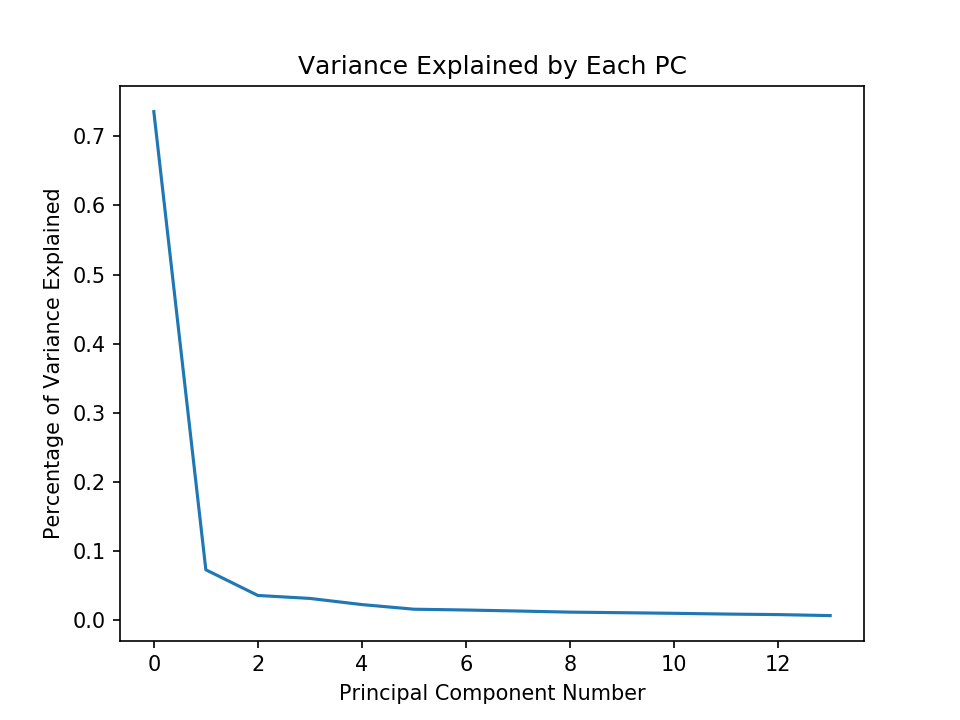

Text(0.5,1,'Variance Explained by Each PC')

In [25]:
fig, ax = plt.subplots()
ax.plot(np.arange(len(s)), np.square(s)/np.sum(np.square(s)))
ax.set_xlabel("Principal Component Number")
ax.set_ylabel("Percentage of Variance Explained")
ax.set_title("Variance Explained by Each PC")

## Low Rank Approximation of Deformation Fields

We have $$X = USV^T$$

Rank-$k$ approximation determined by $$X \approx U_k S_k V_k^T$$

(14, 1500)


<IPython.core.display.Javascript object>


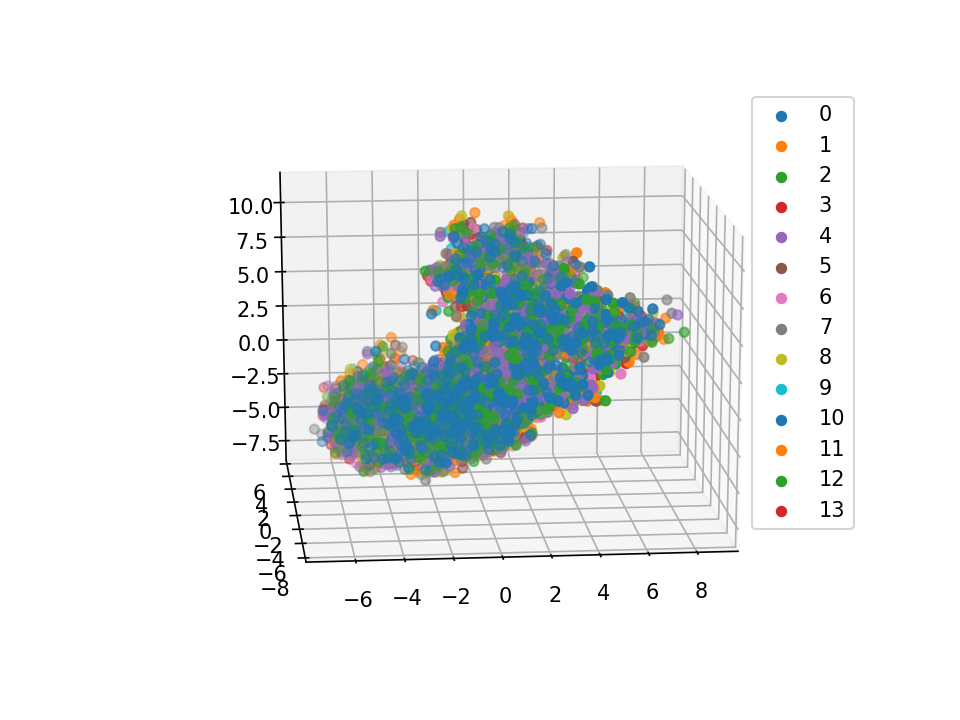

In [26]:
k = 14
approx = np.matmul(np.matmul(u[:,:k], np.diag(s[:k])), vh[:k,:])
print approx.shape

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

for view in range(14): 
    rough = approx[view].reshape((approx.shape[-1]/3, 3), order="F")
    rough += mean_shape
    ax.scatter(rough[:,0], rough[:,1], rough[:,2], label=view)
    
ax.legend()

# ax.scatter(source_cloud[:,0], source_cloud[:,1], source_cloud[:,2])



We can see that low rank approximations of the deformation + initial mean shape recapitulate the unaligned shapes that were directly extracted from Slicer. (Expected) 

## Visualization of Principal Components of the Deformation Field

Text(0.5,0.92,'Principal Component #0')

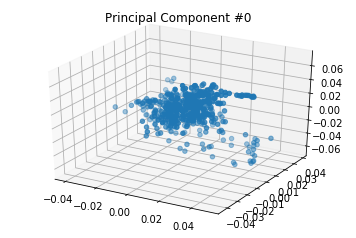

In [10]:
pc_idx = 0

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

pc = vh[pc_idx,:]
pc = pc.reshape((vh.shape[-1]/3, 3), order="F")
ax.scatter(pc[:, 0], pc[:, 1], pc[:, 2])


ax.set_title("Principal Component #%d"%pc_idx)

In [11]:
import ipyvolume as ipv

## Wiggling with the first mode

In [27]:
pc_idx = 0
n_loops = 100
scales = 20*np.sin(np.arange(-2*np.pi, 2*np.pi))

ipv.figure()

all_frames = []
for scale in scales: 
    pc = vh[pc_idx,:].reshape((vh.shape[-1]/3, 3), order="F")
    X = mean_shape + pc*scale
    all_frames.append(X)

all_frames = np.array(all_frames)
    
s = ipv.scatter(all_frames[:, :, 0], all_frames[:, :, 1], all_frames[:, :, 2])

ipv.xyzlim(-8, 8)

ipv.animation_control(s)
ipv.show()

VkJveChjaGlsZHJlbj0oRmlndXJlKGFuaW1hdGlvbj0yMDAuMCwgY2FtZXJhPVBlcnNwZWN0aXZlQ2FtZXJhKGZvdj00Ni4wLCBwb3NpdGlvbj0oMC4wLCAwLjAsIDIuMCksIHF1YXRlcm5pb27igKY=


## Wiggling of the second mode

In [13]:
pc_idx = 1
n_loops = 100
scales = 20*np.sin(np.arange(-2*np.pi, 2*np.pi))

ipv.figure()

all_frames = []
for scale in scales: 
    pc = vh[pc_idx,:].reshape((vh.shape[-1]/3, 3), order="F")
    X = mean_shape + pc*scale
    all_frames.append(X)

all_frames = np.array(all_frames)
    
s = ipv.scatter(all_frames[:, :, 0], all_frames[:, :, 1], all_frames[:, :, 2])

ipv.xyzlim(-8, 8)

ipv.animation_control(s)
ipv.show()

VkJveChjaGlsZHJlbj0oRmlndXJlKGFuaW1hdGlvbj0yMDAuMCwgY2FtZXJhPVBlcnNwZWN0aXZlQ2FtZXJhKGZvdj00Ni4wLCBwb3NpdGlvbj0oMC4wLCAwLjAsIDIuMCksIHF1YXRlcm5pb27igKY=


In [14]:
all_means = []
all_disparities = []

for i, (seg_path, identifier) in enumerate(segmentation_list):
    identifier = identifier.replace(" ", "")
    mean_shape, _, _, _, _, disparities = read_from_file("LOO_" + segmentation_list[i][1].replace(" ", ""))
    all_means.append(mean_shape)
    all_disparities.append(disparities)

    

reading structures from pickle
------------------------------
reading structures from pickle
------------------------------
reading structures from pickle
------------------------------
reading structures from pickle
------------------------------
reading structures from pickle
------------------------------
reading structures from pickle
------------------------------
reading structures from pickle
------------------------------
reading structures from pickle
------------------------------
reading structures from pickle
------------------------------
reading structures from pickle
------------------------------
reading structures from pickle
------------------------------
reading structures from pickle
------------------------------
reading structures from pickle
------------------------------
reading structures from pickle
------------------------------
reading structures from pickle
------------------------------


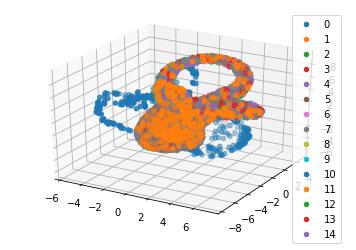

In [15]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

for i, shape in enumerate(all_means): 
    ax.scatter(shape[:,0], shape[:,1], shape[:,2], label=i)

ax.legend()
    

In [16]:
mean_diffs = np.zeros((len(all_means), len(all_means)))

for i, mean1 in enumerate(all_means): 
    for j, mean2 in enumerate(all_means): 
        if j >= i: 
            continue
        mean_diffs[i,j] = np.linalg.norm(mean1-mean2)


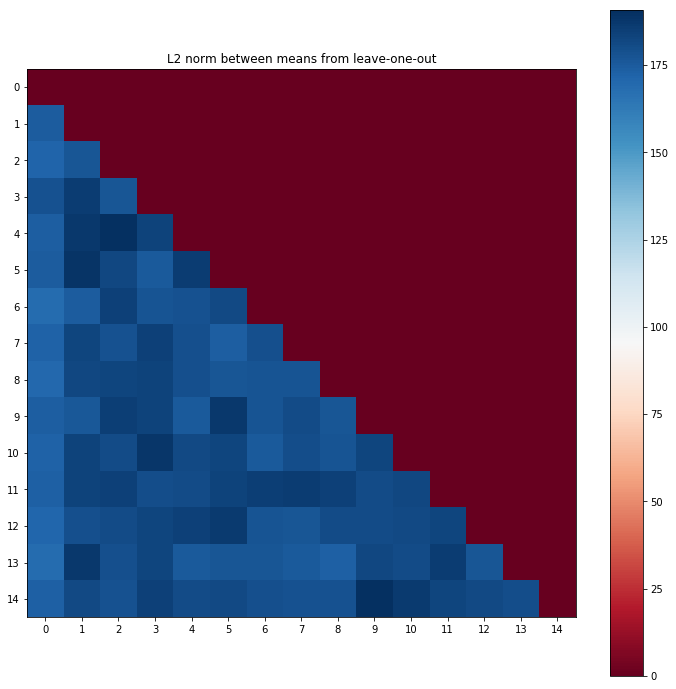

In [17]:
fig, ax = plt.subplots(figsize=(10,10))
im = ax.imshow(mean_diffs, cmap="RdBu")

# We want to show all ticks...
ax.set_xticks(np.arange(len(all_means)))
ax.set_yticks(np.arange(len(all_means)))

ax.set_title("L2 norm between means from leave-one-out")
fig.tight_layout()
plt.colorbar(im)
plt.show()

In [18]:
np.array(all_disparities).shape

(15, 14, 500)

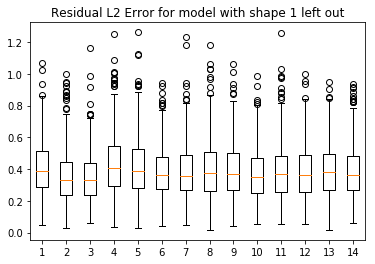

In [19]:
disp_vis_id = 1 
fig1, ax1 = plt.subplots()
ax1.set_title('Residual L2 Error for model with shape %d left out'%disp_vis_id)
ax1.boxplot(all_disparities[disp_vis_id])
plt.show()

In [138]:
plt.close("all")